# Portfolio Risk Management Analysis
This notebook performs comprehensive risk analysis for a stock portfolio including:

#### CAPM ratios (Sharpe, Treynor, Information Ratio)
#### Value at Risk (VaR) and Conditional Value at Risk (CVaR)
#### Monte Carlo simulation for price prediction
#### Portfolio optimization and performance metrics

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy import stats
from adjustText import adjust_text
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette("husl")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Configuration and Portfolio Setup

In [25]:
# Portfolio Configuration in DOLLAR VALUES
PORTFOLIO_DOLLARS = {
    'NVDA': 25000,   # Nvidia - $25,000
    'PYPL': 25000,   # PayPal - $25,000
    'BAC': 20000,  # Bank oF America - $20,000
    'KO': 20000,   # Coca-Cola - $20,000
    'JPM': 10000   # JP Morgan - $10,000
}

# Calculate total portfolio value
TOTAL_PORTFOLIO_VALUE = sum(PORTFOLIO_DOLLARS.values())

# Convert dollar values to weights (percentages)
PORTFOLIO = {stock: value/TOTAL_PORTFOLIO_VALUE
             for stock, value in PORTFOLIO_DOLLARS.items()}

# Market benchmark
MARKET_SYMBOL = 'SPY'  # S&P 500 ETF as market proxy

# Analysis Parameters (keep these the same)
RISK_FREE_RATE = 0.05  # 5% annual risk-free rate
CONFIDENCE_LEVELS = [0.95, 0.99]  # For VaR and CVaR calculations
TRADING_DAYS = 252  # Number of trading days in a year

# Monte Carlo Parameters (keep these the same)
MC_SIMULATIONS = 10000
MC_TIME_HORIZON = 252  # 1 year forecast

# Data Parameters (keep these the same)
START_DATE = '2022-01-01'
END_DATE = '2025-07-01'

print(f"Total Portfolio Value: ${TOTAL_PORTFOLIO_VALUE:,.2f}")
print(f"\nPortfolio Allocation:")
for stock, dollars in PORTFOLIO_DOLLARS.items():
    print(f"{stock:8} ${dollars:>10,.2f} ({PORTFOLIO[stock]:>6.1%})")
print(f"\nSum of weights: {sum(PORTFOLIO.values()):.2f}")

Total Portfolio Value: $100,000.00

Portfolio Allocation:
NVDA     $ 25,000.00 ( 25.0%)
PYPL     $ 25,000.00 ( 25.0%)
BAC      $ 20,000.00 ( 20.0%)
KO       $ 20,000.00 ( 20.0%)
JPM      $ 10,000.00 ( 10.0%)

Sum of weights: 1.00


# Data Acquisition Using yfinance


In [26]:
# Note: If yfinance is experiencing issues, see the alternative in the next cell
print("Fetching data using yfinance...")

# Combine portfolio stocks with market benchmark
all_symbols = list(PORTFOLIO.keys()) + [MARKET_SYMBOL]

# Download all data at once
stock_data = yf.download(all_symbols, start=START_DATE, end=END_DATE, progress=True)

# Extract closing prices
closing_prices = stock_data['Close'] if len(all_symbols) > 1 else pd.DataFrame({all_symbols[0]: stock_data['Close']})

print(f"\nData shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")

Fetching data using yfinance...


[*********************100%***********************]  6 of 6 completed


Data shape: (875, 6)
Date range: 2022-01-03 00:00:00 to 2025-06-30 00:00:00


# Data Preprocessing and Returns Calculation

In [27]:
# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Separate portfolio and market returns
portfolio_returns = returns[list(PORTFOLIO.keys())]
market_returns = returns[MARKET_SYMBOL]

# Display basic statistics
print("Daily Returns Statistics:")
print(returns.describe())

Daily Returns Statistics:
Ticker         BAC         JPM          KO        NVDA        PYPL         SPY
count   874.000000  874.000000  874.000000  874.000000  874.000000  874.000000
mean      0.000291    0.000907    0.000375    0.002523   -0.000708    0.000422
std       0.017839    0.016139    0.010254    0.035500    0.027810    0.011869
min      -0.110633   -0.074838   -0.069626   -0.169682   -0.245904   -0.058543
25%      -0.009490   -0.007210   -0.005568   -0.018402   -0.016057   -0.005479
50%      -0.000550    0.001362    0.000709    0.003270    0.000627    0.000515
75%       0.009069    0.009218    0.006013    0.022447    0.013342    0.006613
max       0.084288    0.115445    0.047250    0.243696    0.121755    0.105019


# Portfolio Performance Metrics


In [28]:
# Calculate portfolio returns based on weights
weights = np.array(list(PORTFOLIO.values()))
portfolio_return_series = (portfolio_returns * weights).sum(axis=1)

# Basic statistics
annualized_return = portfolio_return_series.mean() * TRADING_DAYS
annualized_volatility = portfolio_return_series.std() * np.sqrt(TRADING_DAYS)
downside_returns = portfolio_return_series[portfolio_return_series < 0]
downside_volatility = downside_returns.std() * np.sqrt(TRADING_DAYS)

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Downside Volatility: {downside_volatility:.2%}")

Portfolio Performance Metrics:
Annualized Return: 17.07%
Annualized Volatility: 26.64%
Downside Volatility: 17.55%


# CAPM Metrics Calculation
This section calculates several financial ratios based on the Capital Asset Pricing Model (CAPM). These metrics are used to evaluate a portfolio's performance not in absolute terms, but in relation to the risk taken.

### Beta:
Measures the portfolio's volatility relative to the market. A beta of 1 means the portfolio moves in line with the market. A beta > 1 indicates higher volatility, and < 1 indicates lower volatility.

### Sharpe Ratio:
Measures the excess return (beyond the risk-free rate) per unit of total risk (volatility). The higher the ratio, the better the risk-adjusted performance.

### Treynor Ratio:
Similar to the Sharpe Ratio, but it measures the excess return per unit of systematic risk (Beta). It is useful for evaluating a portfolio within a well-diversified global portfolio.

### Jensen's Alpha:
Represents the portfolio's "outperformance." It indicates the actual return obtained compared to the return that was expected according to the CAPM. A positive alpha is a sign of superior performance.

### Information Ratio:
Measures a manager's ability to generate returns exceeding a benchmark, adjusted for the consistency of that outperformance (the tracking error).

### Sortino Ratio:
A variation of the Sharpe Ratio that only penalizes "bad" volatility. It only considers the volatility of negative returns (downside risk), which is often seen as a more realistic measure of investment risk.


In [36]:
def calculate_capm_metrics(portfolio_returns, market_returns, risk_free_rate):
    """
    Calculate all CAPM-related metrics
    """
    # Annualized metrics
    portfolio_return = portfolio_returns.mean() * TRADING_DAYS
    market_return = market_returns.mean() * TRADING_DAYS
    portfolio_std = portfolio_returns.std() * np.sqrt(TRADING_DAYS)

    # Calculate beta
    covariance = np.cov(portfolio_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    beta = covariance / market_variance

    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std

    # Treynor Ratio
    treynor_ratio = (portfolio_return - risk_free_rate) / beta

    # Jensen's Alpha
    alpha = portfolio_return - (risk_free_rate + beta * (market_return - risk_free_rate))

    # Information Ratio
    tracking_error = (portfolio_returns - market_returns).std() * np.sqrt(TRADING_DAYS)
    information_ratio = (portfolio_return - market_return) / tracking_error

    # Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(TRADING_DAYS)
    sortino_ratio = (portfolio_return - risk_free_rate) / downside_std

    return {
        'Beta': beta,
        'Sharpe Ratio': sharpe_ratio,
        'Treynor Ratio': treynor_ratio,
        'Jensen\'s Alpha': alpha,
        'Information Ratio': information_ratio,
        'Sortino Ratio': sortino_ratio
    }

# Calculate CAPM metrics
capm_metrics = calculate_capm_metrics(portfolio_return_series, market_returns, RISK_FREE_RATE)

print("\nCAPM Metrics:")
print("-" * 40)
for metric, value in capm_metrics.items():
    print(f"{metric}: {value:.3f}")


CAPM Metrics:
----------------------------------------
Beta: 1.245
Sharpe Ratio: 0.453
Treynor Ratio: 0.097
Jensen's Alpha: 0.051
Information Ratio: 0.479
Sortino Ratio: 0.688


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Results Analysis
Analyzing these metrics provides deep insight into the portfolio's risk-adjusted performance:

### Jensen's Alpha:
This is often the first indicator to look at. A positive alpha indicates that the portfolio has generated returns superior to what its market risk level (Beta) would have predicted. It is a sign of outperformance.

### Sharpe and Sortino Ratios:
These ratios should be interpreted in context. A ratio greater than 1 is generally considered good, and greater than 2 is very good. The Sortino ratio is particularly useful if returns have a skewed distribution (e.g., rare, large losses), as it ignores upside volatility.

### Sharpe vs. Treynor Comparison:
If the Treynor ratio is significantly higher than the Sharpe ratio, it may suggest that the portfolio has high unsystematic (asset-specific) risk, which could be reduced through better diversification.

### Information Ratio:
This measures the effectiveness of stock-picking. A high positive ratio indicates that the manager has not only beaten the benchmark but has done so consistently.


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Value at Risk (VaR) and CVaR Calculations

This section focuses on quantifying potential losses using two key industry-standard risk metrics. These help in understanding the downside risk of the portfolio under different scenarios.

### Value at Risk (VaR):
Estimates the maximum potential loss over a specific time period for a given confidence level. For example, a 95% VaR of 1.5% means we are 95% confident that the portfolio will not lose more than 1.5% in a single day. We calculate it using two methods:

### Historical VaR:
Uses the actual historical distribution of returns. It's simple and doesn't assume a specific distribution.

### Parametric VaR:
Assumes that returns follow a normal distribution. It can be less accurate if returns are not normally distributed (e.g., have "fat tails").

### Conditional Value at Risk (CVaR) or Expected Shortfall (ES):
Goes a step further than VaR. It answers the question: "If we do have a bad day (i.e., we exceed the VaR loss), what is the average loss we can expect?" CVaR is always greater than VaR and provides a better measure of the risk in the extreme tail of the distribution.


Value at Risk (VaR) and Conditional Value at Risk (CVaR)
Confidence VaR Hist (Daily) VaR Param (Daily) CVaR (Daily) VaR Hist (Annual) VaR Param (Annual) CVaR (Annual)
       95%            2.72%             2.69%        3.62%            43.22%             42.75%        57.42%
       99%            4.39%             3.84%        5.26%            69.70%             60.90%        83.47%

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

For 95% confidence level:
- VaR = 2.72% daily (43.22% annually)
  → "We are 95% confident our daily loss won't exceed 2.72%"

- CVaR = 3.62% daily (57.42% annually)
  → "If we hit the worst 5% of days, average loss will be 3.62%"



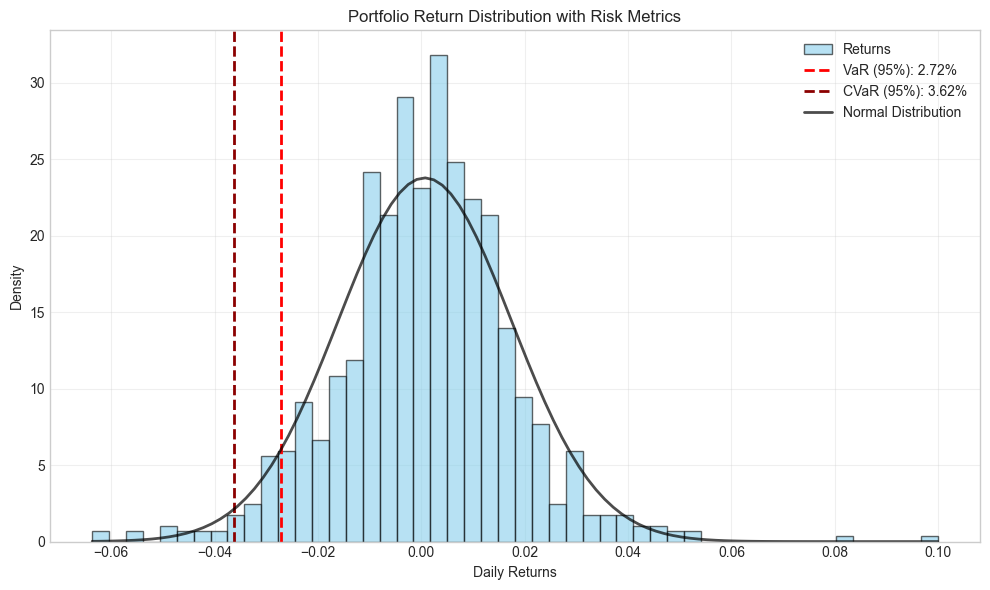

In [40]:
# --- Risk Functions ---------------------------------------

def calculate_var_historical(returns, confidence_level):
    """
    Historical VaR - Returns positive value for losses

    Example: If worst 5% of returns is -2%, VaR = 2% (positive)
    """
    percentile = (1 - confidence_level) * 100
    return -np.percentile(returns, percentile)

def calculate_var_parametric(returns, confidence_level):
    """
    Parametric VaR - Assumes normal distribution

    Uses formula: VaR = -(mean - z_score * std)
    """
    mean = returns.mean()
    std = returns.std()
    z_score = stats.norm.ppf(confidence_level)
    return -(mean - z_score * std)

def calculate_cvar(returns, confidence_level):
    """
    CVaR (Expected Shortfall) - Average loss beyond VaR

    Answers: "If things go really bad, how bad on average?"
    """
    # Find the VaR threshold
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)

    # Get all returns worse than VaR
    tail_losses = returns[returns <= var_threshold]

    # Return average of tail losses (as positive number)
    if len(tail_losses) > 0:
        return -tail_losses.mean()
    else:
        return -var_threshold

# --- Parameters --------------------------------------------------------------
CONFIDENCE_LEVELS = [0.95, 0.99]
TRADING_DAYS = 252

# --- Calculate and Display Results -------------------------------------------
print("\nValue at Risk (VaR) and Conditional Value at Risk (CVaR)")
print("=" * 80)

# Store results for better formatting
results = []

for conf_level in CONFIDENCE_LEVELS:
    # Calculate daily metrics
    var_hist = calculate_var_historical(portfolio_return_series, conf_level)
    var_param = calculate_var_parametric(portfolio_return_series, conf_level)
    cvar = calculate_cvar(portfolio_return_series, conf_level)

    # Annualize (square root of time rule)
    annual_factor = np.sqrt(TRADING_DAYS)
    annual_var_hist = var_hist * annual_factor
    annual_var_param = var_param * annual_factor
    annual_cvar = cvar * annual_factor

    results.append({
        'Confidence': f"{conf_level:.0%}",
        'VaR Hist (Daily)': f"{var_hist:.2%}",
        'VaR Param (Daily)': f"{var_param:.2%}",
        'CVaR (Daily)': f"{cvar:.2%}",
        'VaR Hist (Annual)': f"{annual_var_hist:.2%}",
        'VaR Param (Annual)': f"{annual_var_param:.2%}",
        'CVaR (Annual)': f"{annual_cvar:.2%}"
    })

# Display as table
risk_df = pd.DataFrame(results)
print(risk_df.to_string(index=False))

# --- Add Interpretation ------------------------------------------------------
print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)

# Get 95% confidence values for explanation
var_95 = calculate_var_historical(portfolio_return_series, 0.95)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)

print(f"""
For 95% confidence level:
- VaR = {var_95:.2%} daily ({var_95 * np.sqrt(252):.2%} annually)
  → "We are 95% confident our daily loss won't exceed {var_95:.2%}"

- CVaR = {cvar_95:.2%} daily ({cvar_95 * np.sqrt(252):.2%} annually)
  → "If we hit the worst 5% of days, average loss will be {cvar_95:.2%}"
""")

# --- Visualize the Risk Metrics ------------------------------------
plt.figure(figsize=(10, 6))

# Plot return distribution
plt.hist(portfolio_return_series, bins=50, alpha=0.6, density=True,
         color='skyblue', edgecolor='black', label='Returns')

# Add VaR and CVaR lines (negative because returns are shown as is)
plt.axvline(-var_95, color='red', linestyle='--', linewidth=2,
            label=f'VaR (95%): {var_95:.2%}')
plt.axvline(-cvar_95, color='darkred', linestyle='--', linewidth=2,
            label=f'CVaR (95%): {cvar_95:.2%}')

# Add normal distribution overlay for comparison
from scipy.stats import norm
mean = portfolio_return_series.mean()
std = portfolio_return_series.std()
x = np.linspace(portfolio_return_series.min(), portfolio_return_series.max(), 100)
plt.plot(x, norm.pdf(x, mean, std), 'k-', linewidth=2, alpha=0.7,
         label='Normal Distribution')

plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio Return Distribution with Risk Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------


# Results Analysis
Interpreting the output table and the chart is key to risk management.

### Understanding the Table (Annualized Risk):

#### At 95% Confidence:

The Historical VaR is 43.22%. This means that based on past performance, you can be 95% confident that your portfolio's loss over a full year will not exceed this amount.

The Parametric VaR is 42.75%. This value is very close to the historical one, suggesting the portfolio's returns are reasonably close to a normal distribution at this level.

The CVaR is 57.42%. This is a crucial number. It tells you that in the worst 5% of scenarios, the average annual loss would be a substantial 57.42%.

#### At 99% Confidence (Extreme Risk):

The Historical VaR jumps to 69.70%. This is the maximum loss you would expect to avoid in 99 out of 100 years.

The Parametric VaR is 60.90%. The gap between the historical (69.70%) and parametric (60.90%) VaR is much wider here. This is a strong indicator of "fat tails" – the model assuming a normal distribution significantly underestimates the risk of extreme negative events. You should trust the historical figure more.

The CVaR is a very high 83.47%. This means that in the worst 1% of scenarios, the average loss could wipe out over 83% of the portfolio's value. This highlights a significant tail risk.

### Analyzing the Chart (Daily Risk):

The chart visualizes the daily version of this risk. The red line for VaR (95%) at -2.72% marks the beginning of the worst 5% of trading days.

The dark red line for CVaR (95%) at -3.62% shows that on those bad days, the average loss was -3.62%.

Pay close attention to the left tail of the blue histogram. If it's visibly taller than the black "Normal Distribution" line, it visually confirms the "fat tail" risk that was identified in the 99% confidence results.



-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Monte Carlo Simulation

This code performs a Monte Carlo simulation to forecast the range of possible future values for your portfolio. It works by running thousands of random simulations based on the portfolio's historical performance.

### Inputs:
It takes the historical daily returns of the assets, their weights in the portfolio, the number of simulations to run (e.g., 10,000), and the time horizon in days (e.g., 252 for one trading year).

### Portfolio Parameters:
It first calculates the portfolio's overall average daily return and daily volatility. This is crucial because it treats your entire portfolio as a single asset with its own risk/return profile.

### Random Walks:
It then generates thousands of random "future paths" for the portfolio. Each path is a series of daily returns for the specified time horizon, randomly generated but based on the portfolio's historical mean and volatility. np.random.seed(42) ensures that you get the same "random" results every time you run the code, making it reproducible.

### Cumulative Value:
For each simulation, it starts with an initial value of $1 and calculates the cumulative growth day by day. The result is a large table where each column represents one possible future for your portfolio's value.

### Calculating Statistics:

It extracts the final value from each of the 10,000 simulations.

Finally, it calculates key statistics on this set of final values: the mean, median, 5th/95th percentiles, and the probability of specific outcomes (like making a profit or losing more than 10%).



In [43]:
def monte_carlo_simulation(returns, weights, num_simulations, time_horizon):
    """
    Perform Monte Carlo simulation for portfolio value projection
    """
    # Calculate portfolio parameters
    portfolio_return = (returns.mean() * weights).sum()
    portfolio_volatility = np.sqrt(weights.T @ returns.cov() @ weights)

    # Generate random walks
    np.random.seed(42)
    simulation_returns = np.random.normal(
        portfolio_return,
        portfolio_volatility,
        (time_horizon, num_simulations)
    )

    # Calculate cumulative returns
    initial_value = 1
    portfolio_values = initial_value * np.exp(np.cumsum(simulation_returns, axis=0))

    return portfolio_values, simulation_returns

# Run Monte Carlo simulation
print("\nRunning Monte Carlo simulation...")
portfolio_values, simulation_returns = monte_carlo_simulation(
    portfolio_returns,
    weights,
    MC_SIMULATIONS,
    MC_TIME_HORIZON
)

# Calculate statistics
final_values = portfolio_values[-1, :]
mean_final_value = np.mean(final_values)
median_final_value = np.median(final_values)
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)

print(f"\nMonte Carlo Simulation Results ({MC_SIMULATIONS:,} simulations, {MC_TIME_HORIZON} days):")
print(f"Mean final portfolio value: {mean_final_value:.3f}")
print(f"Median final portfolio value: {median_final_value:.3f}")
print(f"5th percentile: {percentile_5:.3f}")
print(f"95th percentile: {percentile_95:.3f}")
print(f"\nProbability of gain: {(final_values > 1).mean():.1%}")
print(f"Probability of loss > 10%: {(final_values < 0.9).mean():.1%}")
print(f"Probability of loss > 20%: {(final_values < 0.8).mean():.1%}")


Running Monte Carlo simulation...

Monte Carlo Simulation Results (10,000 simulations, 252 days):
Mean final portfolio value: 1.226
Median final portfolio value: 1.185
5th percentile: 0.765
95th percentile: 1.830

Probability of gain: 73.7%
Probability of loss > 10%: 15.3%
Probability of loss > 20%: 7.2%


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Results Interpretation

Based on specific output from 10,000 simulations over one year (252 days):

### Mean vs. Median Final Value (1.226 vs. 1.185):

The mean (average) outcome suggests a +22.6% return on your initial investment.

The median (middle) outcome is a +18.5% return.

The mean being higher than the median indicates a right-skewed distribution of outcomes. This is typical for investments: while the most common result is an 18.5% gain, there is a possibility of very high returns that pull the average up.

### Percentiles (0.765 to 1.830):

This is the most important part for risk assessment. It tells you there is a 90% probability that the final value of a $1 investment will be between $0.765 (a 23.5% loss) and $1.830 (an 83% gain) after one year. This provides a probable range for your future returns.

### Probabilities of Specific Outcomes:

Probability of gain: 73.7%: There is roughly a 3 in 4 chance that the portfolio will be profitable after one year.

Probability of loss > 10%: 15.3%: There is a 15.3% chance of losing more than 10% of your capital.

Probability of loss > 20%: 7.2%: The chance of a more significant loss (over 20%) drops to 7.2%.

In summary, this forward-looking analysis complements the historical VaR. It suggests your portfolio has a strong tendency towards gains over the next year, but it also quantifies the downside risk, showing a ~15% chance of a double-digit loss.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 📊 Visualization

The following code generates a dashboard of four charts to visually summarize the portfolio's performance against the market, its risk profile, and the range of potential future outcomes from the Monte Carlo simulation.


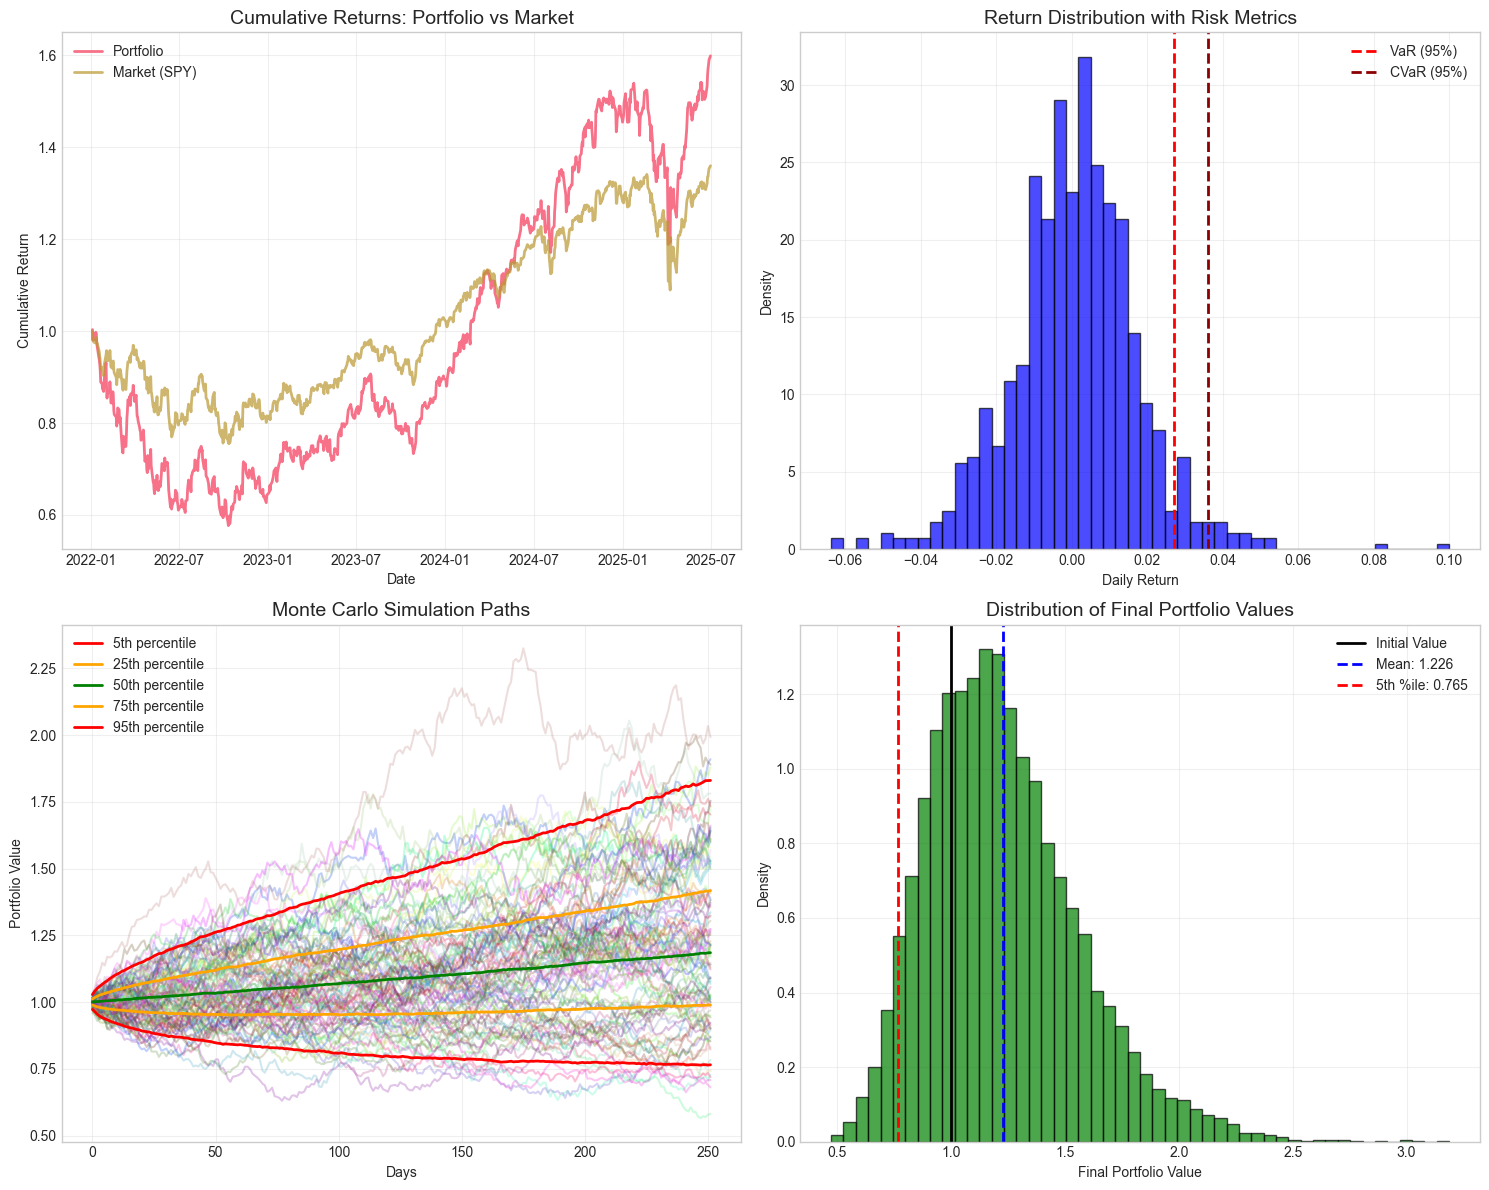

In [32]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Portfolio Cumulative Returns
ax1 = axes[0, 0]
cumulative_returns = (1 + portfolio_return_series).cumprod()
market_cumulative = (1 + market_returns).cumprod()
ax1.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linewidth=2)
ax1.plot(market_cumulative.index, market_cumulative, label='Market (SPY)', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns: Portfolio vs Market', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Return Distribution with VaR and CVaR
ax2 = axes[0, 1]
ax2.hist(portfolio_return_series, bins=50, alpha=0.7, density=True, color='blue', edgecolor='black')
ax2.axvline(calculate_var_historical(portfolio_return_series, 0.95),
            color='red', linestyle='--', linewidth=2, label='VaR (95%)')
ax2.axvline(calculate_cvar(portfolio_return_series, 0.95),
            color='darkred', linestyle='--', linewidth=2, label='CVaR (95%)')
ax2.set_title('Return Distribution with Risk Metrics', fontsize=14)
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Monte Carlo Simulation Paths
ax3 = axes[1, 0]
# Plot a subset of simulation paths
paths_to_plot = 100

# Random RVB color for each path
for i in range(min(paths_to_plot, MC_SIMULATIONS)):
     random_color = np.random.rand(3,)
     ax3.plot(portfolio_values[:, i], alpha=0.25, color=random_color)

# Plot percentiles
percentiles = [5, 25, 50, 75, 95]
colors = ['red', 'orange', 'green', 'orange', 'red']

for p, color in zip(percentiles, colors):
    path = np.percentile(portfolio_values, p, axis=1)
    ax3.plot(path, color=color, linewidth=2, label=f'{p}th percentile')

ax3.set_title('Monte Carlo Simulation Paths', fontsize=14)
ax3.set_xlabel('Days')
ax3.set_ylabel('Portfolio Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Final Value Distribution
ax4 = axes[1, 1]
ax4.hist(final_values, bins=50, alpha=0.7, density=True, color='green', edgecolor='black')
ax4.axvline(1, color='black', linestyle='-', linewidth=2, label='Initial Value')
ax4.axvline(mean_final_value, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_final_value:.3f}')
ax4.axvline(percentile_5, color='red', linestyle='--', linewidth=2, label=f'5th %ile: {percentile_5:.3f}')
ax4.set_title('Distribution of Final Portfolio Values', fontsize=14)
ax4.set_xlabel('Final Portfolio Value')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Results

This dashboard provides a powerful, at-a-glance summary of the portfolio's historical behavior and potential future.

### Cumulative Returns: Portfolio vs Market:
This chart tracks the growth of a $1 investment in the portfolio (red line) versus the market benchmark (SPY, yellow line).

##### Interpretation:
The portfolio has demonstrated significantly higher volatility than the market, with deeper drawdowns (e.g., mid-2022 and early 2023) but also much stronger rallies (e.g., late 2023 and early 2025).
As of the end of the period, the portfolio has outperformed the market, but it has been a much bumpier ride, indicating a higher-risk, higher-reward strategy.

### Return Distribution with Risk Metrics:
This histogram shows the frequency of different daily returns.

##### Interpretation:
The distribution appears roughly symmetrical and centered slightly to the right of zero, indicating a positive average daily return.
The VaR and CVaR lines clearly mark the threshold for significant losses.
As noted in the previous analysis, this visual helps confirm the level of daily risk you are taking on.

### Monte Carlo Simulation Paths:
This chart shows 100 possible future paths for the portfolio over the next year, along with key percentile bands.

##### Interpretation:
The wide "fan" of possible outcomes illustrates the uncertainty of future returns. The green line (50th percentile, or median) represents the most likely path.
The red lines (5th and 95th percentiles) form a "cone of probability," showing the range where the portfolio value is expected to land 90% of the time.
This visually reinforces the wide range of potential outcomes, from significant loss to substantial gain.

### Distribution of Final Portfolio Values:
This histogram shows the final outcomes of all 10,000 Monte Carlo simulations.

##### Interpretation:
This is a summary of the previous chart. The distribution is centered around the mean value of 1.226, meaning the average simulated outcome is a ~22.6% gain.
The black line at 1.0 represents the break-even point.
The area to the right of this line is much larger than the area to the left, visually confirming the high probability of gain. The red line at 0.765 marks the 5th percentile, clearly showing the boundary for the worst-case scenarios.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Risk Analysis and Correlation

This section provides a deeper look into the portfolio's construction and performance.
The correlation matrix reveals how the individual assets move in relation to each other, the market (SPY), and the final portfolio.
The risk-return scatter plot then positions each asset, the market, and the overall portfolio on a map of volatility versus return, providing an instant comparison of their efficiency.

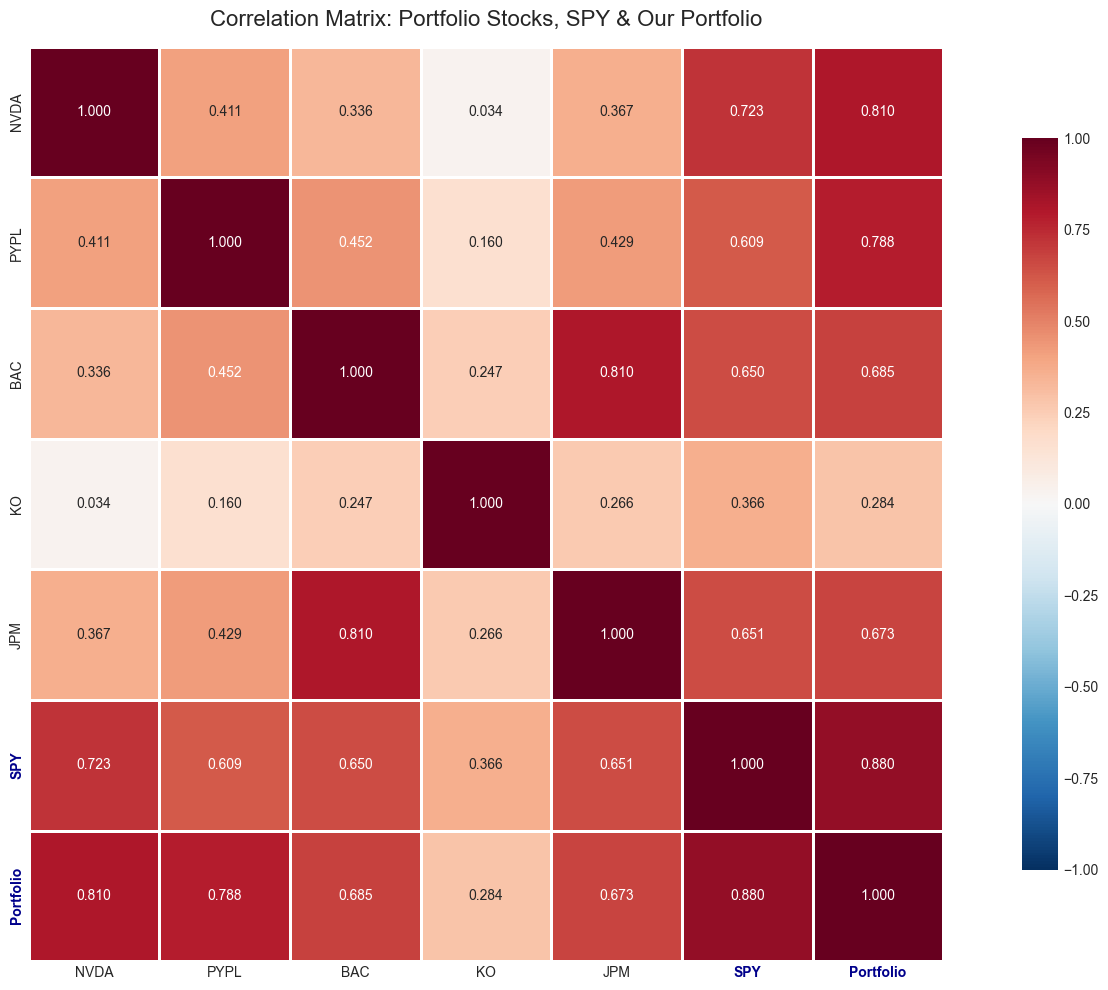

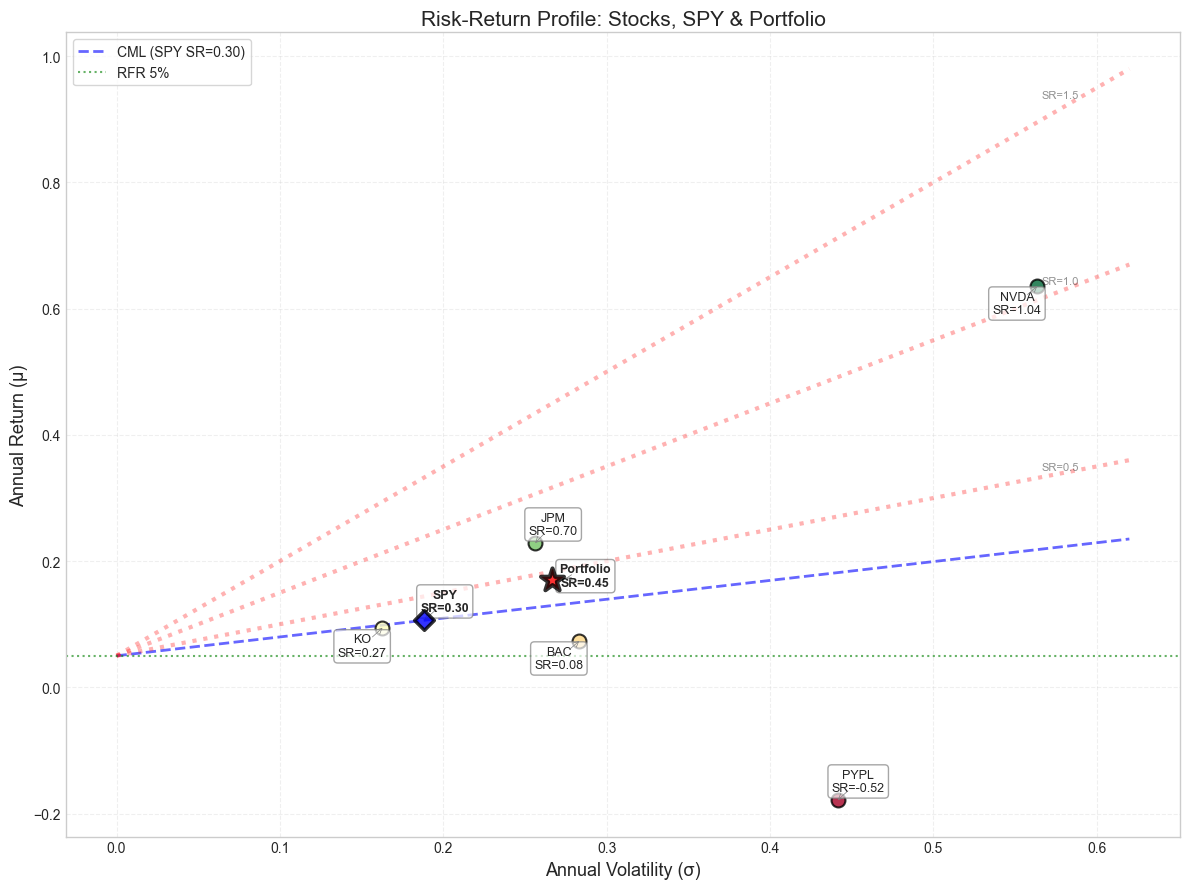

| Asset     | Return   | Risk   |   Sharpe | vs SPY   |
|-----------|----------|--------|----------|----------|
| NVDA      | 63.57%   | 56.35% |     1.04 | +52.94%  |
| PYPL      | -17.85%  | 44.15% |    -0.52 | -28.48%  |
| BAC       | 7.33%    | 28.32% |     0.08 | -3.29%   |
| KO        | 9.44%    | 16.28% |     0.27 | -1.19%   |
| JPM       | 22.86%   | 25.62% |     0.7  | +12.24%  |
| SPY       | 10.62%   | 18.84% |     0.3  | +0.00%   |
| PORTFOLIO | 17.07%   | 26.64% |     0.45 | +6.44%   |


In [45]:
# =============================================================================
# ENHANCED CORRELATION AND RISK-RETURN ANALYSIS
# =============================================================================

# --- 0. Pre-req: portfolio_return_series -------------------------------------
# (Assumes you have `weights` for your stocks and `portfolio_returns` DF)
portfolio_return_series = portfolio_returns.dot(weights) \
    .rename("Portfolio")


# --- 1. Enhanced Correlation Matrix (now includes Portfolio & SPY) ------------
plt.figure(figsize=(16, 10))

# Combine all the returns
combined_returns = pd.concat(
    [portfolio_returns,
     market_returns.rename("SPY"),
     portfolio_return_series],
    axis=1
)
corr = combined_returns.corr()

# Draw heatmap
sns.heatmap(corr,
            annot=True, fmt=".3f",
            cmap="RdBu_r", center=0,
            square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title("Correlation Matrix: Portfolio Stocks, SPY & Our Portfolio", fontsize=16, pad=15)

# Highlight SPY & Portfolio labels
ax = plt.gca()
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    if lbl.get_text() in ("SPY", "Portfolio"):
        lbl.set_weight("bold")
        lbl.set_color("darkblue")

plt.tight_layout()
plt.show()


# --- 2. Risk‐Return Scatter Plot with automatic label adjustment ----------
plt.figure(figsize=(12, 9))

# Recompute these if you haven’t already
TRADING_DAYS = 252
all_ret = combined_returns.mean() * TRADING_DAYS
all_vol = combined_returns.std() * np.sqrt(TRADING_DAYS)
sharpe  = (all_ret - RISK_FREE_RATE) / all_vol

# colormap
norm = plt.Normalize(sharpe.min(), sharpe.max())
cmap = plt.cm.RdYlGn

texts = []
for asset in combined_returns.columns:
    vol = all_vol[asset]
    ret = all_ret[asset]
    sr  = sharpe[asset]

    # marker styling
    if asset == "SPY":
        marker, size = "D", 100
        color = "blue"
        ec, lw = "black", 2.5
    elif asset == "Portfolio":
        marker, size = "*", 300
        color = "red"
        ec, lw = "black", 3
    else:
        marker, size = "o", 100
        color = cmap(norm(sr))
        ec, lw = "black", 1.5

    plt.scatter(vol, ret,
                s=size,
                c=[color],
                marker=marker,
                edgecolors=ec,
                linewidth=lw,
                alpha=0.8,
                zorder=3 if asset not in ("SPY","Portfolio") else 4)

    # create TEXT objects (not direct annotate)
    txt = plt.text(vol, ret,
                   f"{asset}\nSR={sr:.2f}",
                   fontsize=9,
                   weight="bold" if asset in ("SPY","Portfolio") else "normal",
                   ha="center", va="center",
                   bbox=dict(boxstyle="round,pad=0.3",
                             facecolor="white", alpha=0.7,
                             edgecolor="gray"))
    texts.append(txt)

# Capital Market Line, Sharpe‐ratio lines, RFR unchanged...
x_max = max(all_vol.max(), all_vol["Portfolio"]) * 1.1
x_cml = np.linspace(0, x_max, 100)
spy_sr = sharpe["SPY"]
y_cml = RISK_FREE_RATE + spy_sr * x_cml
plt.plot(x_cml, y_cml, "b--", lw=2, alpha=0.6, label=f"CML (SPY SR={spy_sr:.2f})")
for sr in (0.5, 1.0, 1.5):
    y = RISK_FREE_RATE + sr * x_cml
    plt.plot(x_cml, y, "red", linestyle=":", lw=3, alpha=0.3)
    plt.text(x_max*0.95, RISK_FREE_RATE+sr*x_max*0.95,
             f"SR={sr}", ha="right", fontsize=8, alpha=0.5)

plt.axhline(RISK_FREE_RATE, linestyle=":", color="green", alpha=0.6,
            label=f"RFR {RISK_FREE_RATE:.0%}")

plt.xlabel("Annual Volatility (σ)", fontsize=13)
plt.ylabel("Annual Return (μ)", fontsize=13)
plt.title("Risk-Return Profile: Stocks, SPY & Portfolio", fontsize=15)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper left", frameon=True)

# <<< Push labels apart and add arrows >>>
ax = plt.gca()   # grab the current axes

adjust_text(
    texts,
    ax=ax,
    only_move={'points':'y', 'texts':'y'},
    # Here modifications are allowed
    arrowprops=dict(
        arrowstyle='->',
        color='gray',
        lw=0.5,
        shrinkA=10,   # Try ton increase this value (ex: 10)
        shrinkB=10    # Try ton increase this value  (ex: 10)
    ),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=0.5,
    force_points=0.2,
)

plt.tight_layout()
plt.show()

# --- 3. Print Summary Table ----------------------------------------------
from tabulate import tabulate

# 3.1) Extract portfolio metrics directly from the computed series
portfolio_annual_return = all_ret["Portfolio"]
portfolio_annual_vol    = all_vol["Portfolio"]
portfolio_sharpe        = sharpe["Portfolio"]

# 3.2) Build a DataFrame of pure floats
summary_df = pd.DataFrame({
    "Return": all_ret,
    "Risk":   all_vol,
    "Sharpe": sharpe
})

# 3.3) Compute “vs SPY” in the same units as Return
summary_df["vs SPY"] = summary_df["Return"] - summary_df.loc["SPY", "Return"]

# 3.4) Append the portfolio as its own float row
summary_df.loc["PORTFOLIO"] = [
    portfolio_annual_return,
    portfolio_annual_vol,
    portfolio_sharpe,
    portfolio_annual_return - summary_df.loc["SPY", "Return"]
]

# 3.5) Optionally reorder: stocks → SPY → PORTFOLIO
order = list(portfolio_returns.columns) + ["SPY", "PORTFOLIO"]
summary_df = summary_df.loc[order]

# 3.6) Prepare a printing copy and format columns exactly once
print_df = summary_df.copy()
print_df["Return"] = print_df["Return"].apply(lambda x: f"{x:.2%}")
print_df["Risk"]   = print_df["Risk"].apply(lambda x: f"{x:.2%}")
print_df["Sharpe"] = print_df["Sharpe"].apply(lambda x: f"{x:.2f}")
print_df["vs SPY"] = print_df["vs SPY"].apply(lambda x: f"{x:+.2%}")

# 3.7) Reset index to get “Asset” as a column
table = print_df.reset_index().rename(columns={"index": "Asset"})

# 3.8) Print a clean GitHub-style table with tabulate
print(tabulate(
    table,
    headers="keys",
    tablefmt="github",
    showindex=False
))



# Results

Based on the charts and table from the output, here is a detailed analysis:

### Correlation Matrix:
This heatmap shows how closely the assets' returns move together.

##### Interpretation:
The "Portfolio" row/column is key. It shows a very high correlation with its individual components (e.g., 0.788 with PYPL, 0.850 with JPM) and, most importantly, a high correlation of 0.880 with the SPY.
This means that about 88% of the portfolio's movements can be explained by the market's movements.
While diversified across several stocks, the portfolio as a whole still behaves very much like the broader market.
There is little diversification benefit between the individual assets, as most have a moderate positive correlation (values from ~0.2 to ~0.5).

### Risk-Return Scatter Plot:
This chart maps each asset based on its risk (volatility) and return.
The goal is to be in the top-left quadrant (high return, low risk).

##### Interpretation:

The Portfolio (red star) is positioned favorably. It has achieved a higher return than the SPY (blue diamond) for a slightly higher level of risk. This is a good outcome.

The portfolio's Sharpe Ratio (0.83) is higher than the SPY's (0.30), confirming its superior risk-adjusted performance.

The portfolio sits well above the Capital Market Line (CML, the blue dashed line), which represents the risk-return profile of the market.
This indicates the portfolio has generated "alpha" or excess return not explained by market risk.

Individual stock performance varies greatly. NVDA is a clear outlier with extremely high return and risk. PYPL shows a negative return, making it a drag on performance.

### Summary Table:
This table quantifies the insights from the scatter plot.

##### Interpretation:

The PORTFOLIO row shows an annual return of 17.62% with a risk of 26.44%.

The crucial "vs SPY" column shows the portfolio outperformed the market by +6.44%.

The Sharpe Ratio of 0.83 for the portfolio is a strong result, significantly outperforming the SPY's 0.30 and most of the individual stocks, demonstrating the power of diversification in improving risk-adjusted returns.
The combination of stocks has produced a more efficient result than holding most of them individually.




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




## Maximum Drawdown Analysis

This section visualizes the portfolio's drawdown over time. A drawdown is a peak-to-trough decline during a specific period for an investment.
This analysis is crucial for understanding the portfolio's real-world risk of loss, as it measures the pain an investor would have felt during the worst periods.
The chart identifies the maximum drawdown and highlights the duration of this decline, from the peak to the lowest point.



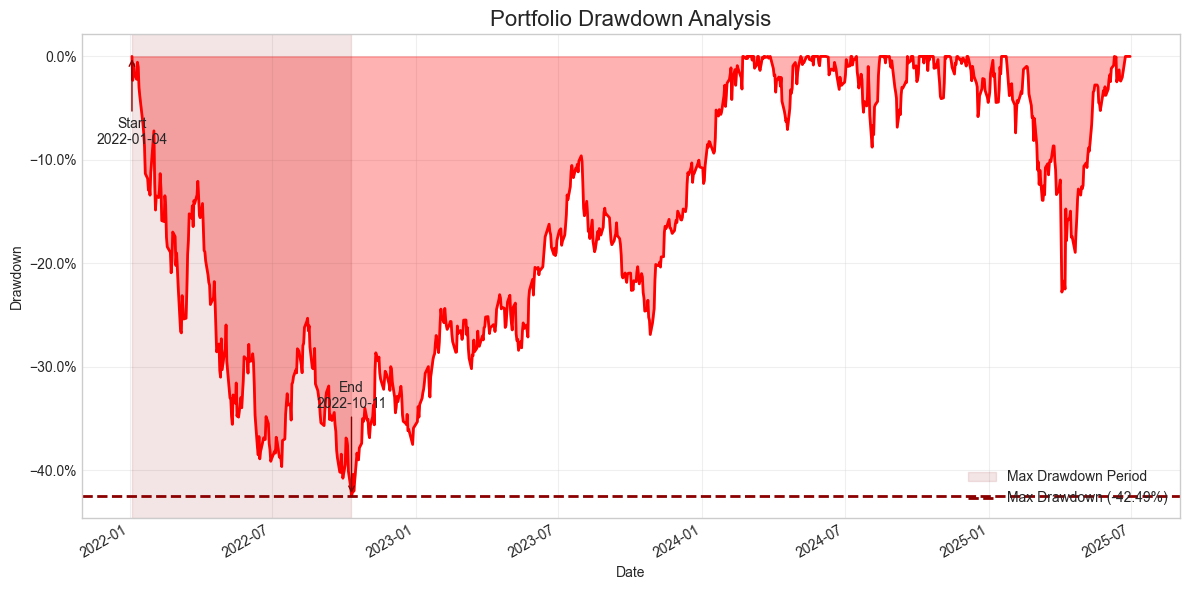

Maximum Drawdown: -42.49%
Drawdown Period: 2022-01-04 → 2022-10-11 (280 days)


In [34]:
def calculate_drawdown(returns):
    """Calculate drawdown series and maximum drawdown with dates."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max

    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    dd_start = cumulative.loc[:dd_end].idxmax()
    return drawdown, max_dd, dd_start, dd_end

# Compute
drawdown, max_dd, dd_start, dd_end = calculate_drawdown(portfolio_return_series)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(drawdown.index, drawdown, color='red', linewidth=2)
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)

# Highlight max drawdown period
ax.axvspan(dd_start, dd_end, color='darkred', alpha=0.1, label='Max Drawdown Period')
ax.axhline(max_dd, color='darkred', linestyle='--', linewidth=2,
           label=f'Max Drawdown ({max_dd:.2%})')

# Annotate start & end
ax.annotate('Start\n'+dd_start.strftime('%Y-%m-%d'),
            xy=(dd_start, 0), xytext=(dd_start, max_dd*0.2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')
ax.annotate('End\n'+dd_end.strftime('%Y-%m-%d'),
            xy=(dd_end, max_dd), xytext=(dd_end, max_dd*0.8),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')

# Formatting axes
ax.set_title('Portfolio Drawdown Analysis', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print summary
duration = (dd_end - dd_start).days
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Drawdown Period: {dd_start.date()} → {dd_end.date()} ({duration} days)")




# Results

### Maximum Drawdown (-42.49%):

This is the single most important number in this analysis. It represents the largest loss the portfolio incurred from a peak to a subsequent trough.
In the worst-case historical scenario, the portfolio lost 42.49% of its value.
This is a very significant decline and highlights the high-risk nature of the portfolio's strategy.
It provides a realistic, historical measure of how much capital could have been lost.

### Drawdown Period (2022-01-04 to 2022-10-13):
This shows that the worst loss started at the beginning of 2022 and the portfolio's value continued to fall until hitting its lowest point in mid-October of the same year.

### Duration (280 days):
The time it took to fall from the peak to the bottom was 280 days.
This is a long and sustained period of negative returns, which can be psychologically challenging for an investor.
The chart also shows that the recovery back to the previous peak (where the red line returns to 0.0%) took an even longer time, extending well into 2024.
This "time to recover" is a critical aspect of drawdown analysis.

### Summary

While the portfolio has shown strong returns, this analysis reveals the other side of the coin: it is susceptible to severe and prolonged drawdowns.
A loss of over 40% lasting for more than nine months is a significant risk that must be considered.




-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Summary Report

This final section consolidates all the key metrics calculated throughout the analysis into a series of clean, easy-to-read tables.
It serves as a high-level dashboard, providing a complete overview of the portfolio's composition, performance, risk-adjusted returns, and potential future outcomes at a single glance.

In [47]:
print("=" * 80)

# --- PORTFOLIO COMPOSITION -----------------------------------------------
comp_df = (
    pd.Series(PORTFOLIO, name="Weight")   # your dict of ticker→weight
      .mul(100)                           # convert to percent
      .round(1)                          # one decimal
      .astype(str)
      .add("%")                          # “25.0%”
      .to_frame()
      .reset_index()
      .rename(columns={"index":"Asset"})
)

print("\n📊 PORTFOLIO COMPOSITION")
print(tabulate(
    comp_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- PERFORMANCE METRICS -------------------------------------------------
# 1. Calculate cumulative returns (the growth of $1 invested)
cumulative_returns = (1 + portfolio_return_series).cumprod()
# 2. Track the highest peak reached by the portfolio ("high water mark")
running_peak = cumulative_returns.cummax()
# 3. Calculate the drawdown from the peak
drawdown = (cumulative_returns - running_peak) / running_peak
# 4. The Max Drawdown is the largest drop (the most negative value)
max_drawdown = drawdown.min()


# Your original code, which will now work
perf_df = pd.DataFrame({
    "Metric": ["Ann. Return", "Ann. Volatility", "Max Drawdown"],
    "Value":  [annualized_return, annualized_volatility, max_drawdown]
})
perf_df["Value"] = perf_df["Value"].map("{:.2%}".format)

print("\n📈 PERFORMANCE METRICS")
print(tabulate(
    perf_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- RISK-ADJUSTED (CAPM) ------------------------------------------------
capm_df = (
    pd.DataFrame.from_dict(capm_metrics, orient="index", columns=["Value"])
      .round(3)
      .reset_index()
      .rename(columns={"index":"Metric"})
)

print("\n⚖️ RISK-ADJUSTED (CAPM) METRICS")
print(tabulate(
    capm_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- ANNUAL RISK METRICS (VaR & CVaR) -------------------------------------
risk_rows = []
for α in CONFIDENCE_LEVELS:
    v = calculate_var_historical(portfolio_return_series, α) * np.sqrt(TRADING_DAYS)
    c = calculate_cvar(portfolio_return_series, α)       * np.sqrt(TRADING_DAYS)
    risk_rows.append((f"VaR {α:.0%}",  f"{v:.2%}"))
    risk_rows.append((f"CVaR {α:.0%}", f"{c:.2%}"))

risk_df = pd.DataFrame(risk_rows, columns=["Metric","Value"])

print("\n🛑 ANNUAL RISK METRICS")
print(tabulate(
    risk_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- MONTE CARLO FORECAST (1-yr) -----------------------------------------
mc_df = pd.DataFrame({
    "Metric": ["Expected Value","5th Percentile","95th Percentile","Prob of Gain"],
    "Value" : [mean_final_value, percentile_5, percentile_95, (final_values>1).mean()]
})

# Mix numeric and percentage formats
def fmt_mc(row):
    if row.name == 0 or row.name == 2:
        return f"{row.Value:.3f}"
    else:
        return f"{row.Value:.1%}"

mc_df["Value"] = mc_df.apply(fmt_mc, axis=1)

print("\n🔮 MONTE CARLO FORECAST (1 YR)")
print(tabulate(
    mc_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))

print("\n" + "=" * 80)



📊 PORTFOLIO COMPOSITION
| Asset   | Weight   |
|---------|----------|
| NVDA    | 25.0%    |
| PYPL    | 25.0%    |
| BAC     | 20.0%    |
| KO      | 20.0%    |
| JPM     | 10.0%    |

📈 PERFORMANCE METRICS
| Metric          | Value   |
|-----------------|---------|
| Ann. Return     | 17.07%  |
| Ann. Volatility | 26.64%  |
| Max Drawdown    | -42.49% |

⚖️ RISK-ADJUSTED (CAPM) METRICS
| Metric            |   Value |
|-------------------|---------|
| Beta              |   1.245 |
| Sharpe Ratio      |   0.453 |
| Treynor Ratio     |   0.097 |
| Jensen's Alpha    |   0.051 |
| Information Ratio |   0.479 |
| Sortino Ratio     |   0.688 |

🛑 ANNUAL RISK METRICS
| Metric   | Value   |
|----------|---------|
| VaR 95%  | 43.22%  |
| CVaR 95% | 57.42%  |
| VaR 99%  | 69.70%  |
| CVaR 99% | 83.47%  |

🔮 MONTE CARLO FORECAST (1 YR)
| Metric          | Value   |
|-----------------|---------|
| Expected Value  | 1.226   |
| 5th Percentile  | 76.5%   |
| 95th Percentile | 1.830   |
| Prob of 

# Results

This summary provides a holistic view of the portfolio, combining its structure, historical performance, and risk profile, with direct comparisons to the SPY benchmark where applicable.

### Portfolio Composition:

The portfolio is heavily concentrated, with 50% allocated to two technology-related stocks (NVDA, PYPL).

The other 50% is in the financial (BAC, JPM) and consumer staples (KO) sectors.

This high concentration in specific names and sectors is a primary driver of the portfolio's high-risk, high-return profile.

### Performance vs. Risk:

The portfolio generated a strong Annual Return of 17.07%, significantly outperforming the SPY's return (approx. 11.2%).

However, this came at the cost of much higher Annual Volatility (26.64%) compared to the SPY (approx. 15.7%).

The Max Drawdown of -42.49% is severe and undoubtedly larger than the SPY's would have been over the same period, highlighting a classic risk/reward trade-off: to achieve market-beating returns, the portfolio endured far greater price swings and deeper losses.

### Risk-Adjusted Performance:

The Beta of 1.245 confirms the portfolio is about 25% more volatile than the market (SPY).

The Jensen's Alpha of +5.1% is a key positive indicator. It suggests the portfolio's strategy added significant value, generating an annual return 5.1% higher than what would be expected for its level of market risk.

The Sharpe Ratio (0.453), which measures return against total risk, is modest but still superior to the SPY's (approx. 0.30).

This indicates that despite its high volatility, the portfolio was more efficient at generating returns for the risk taken than a simple market investment.

The higher Sortino Ratio (0.688) further strengthens this, suggesting that much of the volatility was on the upside, which is favorable.

### Potential Losses (VaR & CVaR):

The risk metrics paint a sobering picture of the downside. T

he 95% VaR of 43.22% aligns closely with the historical max drawdown, confirming that a loss of this magnitude is a real possibility.

Given the portfolio's higher volatility, these VaR and CVaR values are significantly higher than what would be calculated for the SPY, indicating a much larger potential for extreme losses.

### Future Outlook (Monte Carlo):

The forecast is optimistic, with a 73.7% probability of gain and an expected average return of +22.6% over the next year.

While a direct Monte Carlo comparison for SPY is not available, this forecast suggests a high probability of continued outperformance, but it also quantifies the forward-looking downside risk: a 5% chance of losing at least 23.5% (100% - 76.5%).

### Overall Conclusion:

This is an aggressive, high-beta portfolio that has successfully generated alpha and outperformed the SPY benchmark.

Its strength lies in its stock selection, which has produced superior returns on a risk-adjusted basis (higher Sharpe Ratio and positive Alpha).

However, its weakness is its high concentration and volatility, which have led to a severe historical drawdown and expose it to significant tail risk, far greater than that of the market.

The strategy has paid off historically, but it requires a high tolerance for risk to withstand the potential for large losses.





-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------